### Create and configure our spark session

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

# use sparkcontext to indicate the resource of our spark code
# define it as "local", meaning that we'll use the local machine for our resource

jar_driver_path = '/Users/taufiqurrohman/Documents/ds_deploy_gcp/04_sparkml/cache/postgresql-42.7.1.jar'

# sparkcontext serves as the entry point for any spark functionalities

sc = SparkContext(master='local', 
                  appName='logistic')

spark = SparkSession \
            .builder \
            .config("spark.driver.extraClassPath", jar_driver_path) \
            .appName('Logistic regression w/ Spark ML') \
            .getOrCreate()

In [56]:
import json

credential_loc = 'cache/credential_postgres.json'

with open(credential_loc) as json_file:
    postgres_prof = json.load(json_file)

conn_params = {
        'host': postgres_prof['host'],              # local host
        'database': postgres_prof['database'],      # database name, we want to save it to learn_ds_deploy_gcp
        'user': postgres_prof['user'],              # user
        'password': postgres_prof['password']       # password
    }

### Load the Data

In [57]:
jdbc_url = f"jdbc:postgresql://localhost:5432/{conn_params['database']}"
table_name_flights = 'ex3_raw_flights_to2023'

flights = spark.read \
    .format("jdbc") \
    .option("driver", "org.postgresql.Driver") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name_flights) \
    .option("user", postgres_prof['user']) \
    .option("password", postgres_prof['password']) \
    .load()

flights.createOrReplaceTempView('flights')

In [58]:
flights.show(5)

+-------------------+--------------+---------------------+------+-------------------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+--------+
|            FL_DATE|UNIQUE_CARRIER|ORIGIN_AIRPORT_SEQ_ID|ORIGIN|DEST_AIRPORT_SEQ_ID|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|DISTANCE|
+-------------------+--------------+---------------------+------+-------------------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+--------+
|2023-01-02 00:00:00|            9E|              1052907|   BDL|            1295304| LGA|        0800|    0757|     -3.0|    11.0|      0808|     0833|   20.0|        0905|    0853|    -12.0|      0.0|     0.0|   101.0|
|2023-01-03 00:00:00|            9E|              1052907|   BDL|            1295304| LGA|        0800|    0755|    

In [59]:
jdbc_url = f"jdbc:postgresql://localhost:5432/{conn_params['database']}"
table_name_traindays = 'ex3_trainday'

traindays = spark.read \
        .format("jdbc") \
        .option("driver", "org.postgresql.Driver")  \
        .option("url", jdbc_url) \
        .option("dbtable", table_name_traindays) \
        .option("user", postgres_prof['user']) \
        .option("password", postgres_prof['password']) \
        .load()

traindays.createOrReplaceTempView('traindays')

In [60]:
traindays.show(5)

+-------------------+------------+
|            FL_DATE|is_train_day|
+-------------------+------------+
|2023-01-01 00:00:00|        true|
|2023-01-02 00:00:00|        true|
|2023-01-03 00:00:00|        true|
|2023-01-04 00:00:00|       false|
|2023-01-05 00:00:00|       false|
+-------------------+------------+
only showing top 5 rows



### Subset the data for train data and do the transformation

In [61]:
flights.count()

538837

In [62]:
query = '''
    SELECT
        f.DEP_DELAY, 
        f.TAXI_OUT, 
        f.ARR_DELAY, 
        f.DISTANCE
    FROM
        flights f
    JOIN
        traindays t
    ON
        f.FL_DATE == t.FL_DATE
    WHERE
        t.is_train_day == TRUE AND
        f.CANCELLED == 0 AND
        f.DIVERTED == 0
'''

traindata = spark.sql(query)    # execute the query
traindata.describe().show()     # print descriptive statistics from train_data

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|            371799|            371799|            371799|           371799|
|   mean|11.048327187539504|18.194355014402944|5.7618713337045016| 833.997818713875|
| stddev|53.850485575181715| 10.46245055130918|56.397768632897375|602.5116494241315|
|    min|             -52.0|               1.0|             -80.0|             31.0|
|    max|            3024.0|             222.0|            3063.0|           5095.0|
+-------+------------------+------------------+------------------+-----------------+



### Label the data for y-variable

In [76]:
from pyspark.mllib.regression import LabeledPoint   # import the needed library first

def feat_tf(data):
    '''
    creating a LabeledPoint object where the label is a binary value 
    indicating whether 'ARR_DELAY' is less than 15
    '''
    label = LabeledPoint(
        float(data['ARR_DELAY'] < 15),
        [
            # list out all the features for the model here 
            # 'DEP_DELAY', 'TAXI_OUT', and 'DISTANCE'
            data['DEP_DELAY'],
            data['TAXI_OUT'],
            data['DISTANCE']
        ]   
    )
    return label

In [77]:
# convert to rdd format first before applying the function
# resillient distributed dataframe
# before, it was only a spark dataframe, not an rdd

traindata_tf = traindata.rdd.map(feat_tf)
traindata_tf

PythonRDD[128] at RDD at PythonRDD.scala:53

In [78]:
# print some examples to see the output from the to_example transformation
# print top 10 points

print_examples = traindata_tf.take(10)

for example in print_examples:
    print(example)

(0.0,[6.0,55.0,144.0])
(1.0,[6.0,12.0,529.0])
(1.0,[-4.0,26.0,377.0])
(1.0,[-2.0,28.0,377.0])
(1.0,[-10.0,33.0,220.0])
(1.0,[-9.0,21.0,431.0])
(1.0,[-5.0,17.0,610.0])
(1.0,[-2.0,23.0,610.0])
(1.0,[0.0,19.0,596.0])
(1.0,[-5.0,21.0,509.0])


### Training the model

In [66]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

# train the model using logisticregression
# and print the intercept + weights

lrmodel = LogisticRegressionWithLBFGS.train(traindata_tf, intercept=True)
print(lrmodel.intercept, lrmodel.weights)

5.402863200790148 [-0.15315411518048033,-0.12550687571641367,7.103066014261215e-05]


### Trying out prediction

In [68]:
# predict with the specification below

pred_delay = 6      # 6 minutes departure delay
pred_taxiout = 12   # taxi out time for 12 minutes
pred_dist = 594     # flight distance of 594 miles

lrmodel.predict([
    pred_delay,
    pred_taxiout,
    pred_dist
])

1

In [69]:
# to get the probability instead of label
# use clearThreshold 
# to get it back, use setThreshold
# like this >> lrmodel.setThreshold()

lrmodel.clearThreshold()
lrmodel.predict([
    pred_delay,
    pred_taxiout,
    pred_dist
])

0.953471664437452

### Plotting model probablity of on-time arrival based on variables

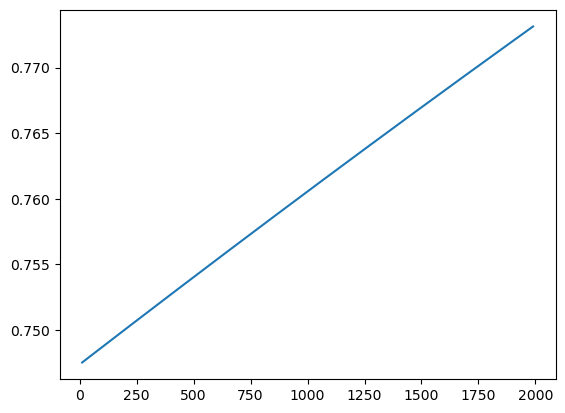

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# assuming that the departure delay is 20 minutes
# and taxi-out time is 10 minutes

pred_dist = np.arange(10, 2000, 10)
prob = [lrmodel.predict([20, 10, d]) for d in pred_dist]
plt.plot(pred_dist, prob)

In [71]:
# save the model
# pass the sparkcontext and the path

lrmodel.save(sc, path='model')

### Evaluating the model

In [75]:
# load the test data

query = '''
    SELECT
        f.DEP_DELAY, 
        f.TAXI_OUT, 
        f.ARR_DELAY, 
        f.DISTANCE
    FROM
        flights f
    JOIN
        traindays t
    ON
        f.FL_DATE == t.FL_DATE
    WHERE
        t.is_train_day == FALSE AND
        f.CANCELLED == 0 AND
        f.DIVERTED == 0
'''

testdata = spark.sql(query)
testdata.count()

155398

In [90]:
# carry out the same pipeline like before

testdata_tf = testdata.rdd.map(feat_tf)
labelpred = testdata_tf.map(lambda pred: (pred.label, lrmodel.predict(pred.features)))

# print the top 5 elements

top_5_elements = labelpred.take(5)

for element in top_5_elements:
    print(element)

(1.0, 0.9880937206328995)
(1.0, 0.988922258452224)
(0.0, 8.092485382174859e-15)
(1.0, 0.9081540181533158)
(1.0, 0.9399941848540777)


In [108]:
threshold = 0.7

def eval(labelpred):

    # filtering cancel and nocancel 

    cancel = labelpred.filter(lambda data: data[1] < 0.7)
    nocancel = labelpred.filter(lambda data: data[1] >= 0.7)
    
    # calculate correct cancel and no cancel 

    corr_cancel = cancel.filter(lambda data: data[0] == int(data[1] >= 0.7)).count()
    corr_nocancel = nocancel.filter(lambda data: data[0] == int(data[1] >= 0.7)).count()

    cancel_denom = cancel.count()
    nocancel_denom = nocancel.count()

    # this is just to make sure that the denominator isn't zero
    # as numbers cannot be divided by zero

    if cancel_denom == 0:
        cancel_denom = 1
    if nocancel_denom == 0:
        nocancel_denom = 1

    # pass it into eval dictionary
        
    eval = {'total_cancel': cancel.count(),
            'correct_cancel': float(corr_cancel) / cancel_denom, 
            'total_noncancel': nocancel.count(), 
            'correct_noncancel': float(corr_nocancel) / nocancel_denom
           }
    
    return eval

In [109]:
eval(labelpred)

{'total_cancel': 42093,
 'correct_cancel': 0.8416126196754805,
 'total_noncancel': 113305,
 'correct_noncancel': 0.9530647367724284}

### Breaking down the code below by printing the output of every steps

In [102]:
# filter by the threshold that if the prob. prediction < 0.7, cancel
# otherwise, carry on with the meeting

cancel = labelpred.filter(lambda data: data[1] < 0.7)
nocancel = labelpred.filter(lambda data: data[1] >= 0.7)

display(cancel.take(5))
display(nocancel.take(5))

[(0.0, 8.092485382174859e-15),
 (0.0, 0.012665483546334804),
 (0.0, 0.09581442607400457),
 (0.0, 1.0347124120488111e-20),
 (0.0, 1.1631986693740263e-06)]

[(1.0, 0.9880937206328995),
 (1.0, 0.988922258452224),
 (1.0, 0.9081540181533158),
 (1.0, 0.9399941848540777),
 (0.0, 0.955115529607967)]

In [105]:
# count how many correct and incorrect cancel
# by comparing it to the data we have

corr_cancel = cancel.filter(lambda data: data[0] == int(data[1] >= 0.7)).count()
corr_nocancel = nocancel.filter(lambda data: data[0] == int(data[1] >= 0.7)).count()

display(corr_cancel)
display(corr_nocancel)

35426

107987